In [11]:
import numpy as np

def compute_eps_per_step(alpha_bar, delta=1e-5, Delta_f0=1.0, eps_clip=np.inf):
    """
    Compute the per-step (eps_t, delta)-LDP privacy budget upper bound
    from the diffusion forward process defined by alpha_bar.

    Parameters
    ----------
    alpha_bar : array-like, shape (T,)
        Cumulative product of alphas (\\bar{alpha}_t), must lie in (0, 1]
        and typically decreases with t.
    delta : float
        Failure probability δ (e.g., 1e-5).
    Delta_f0 : float
        Upper bound on the L2 sensitivity ||x0 - x0'||_2.
    eps_clip : float
        Optional upper bound to clip eps values, preventing numerical
        explosion when alpha_bar → 1.

    Returns
    -------
    eps_t : ndarray, shape (T,)
        Per-step epsilon upper bound.
    """
    alpha_bar = np.asarray(alpha_bar, dtype=np.float64)
    if np.any(alpha_bar <= 0) or np.any(alpha_bar > 1):
        raise ValueError("alpha_bar must be in (0, 1].")
    if not (0 < delta < 1):
        raise ValueError("delta must be in (0, 1).")
    if Delta_f0 <= 0:
        raise ValueError("Delta_f0 must be > 0.")

    # Avoid division by zero: when alpha_bar is close to 1,
    # (1 - alpha_bar) becomes very small and eps can blow up
    denom = np.sqrt(np.maximum(1.0 - alpha_bar, 1e-12))
    a_t = (np.sqrt(np.maximum(alpha_bar, 0.0)) * Delta_f0) / denom

    tail = np.sqrt(2.0 * np.log(1.0 / delta))
    eps_t = 0.5 * (a_t ** 2) + a_t * tail

    if np.isfinite(eps_clip):
        eps_t = np.minimum(eps_t, eps_clip)

    return eps_t


def compute_alpha_bar(beta_start, beta_end, T):
    """
    Compute alpha_bar from a linear beta schedule.
    """
    betas = np.linspace(beta_start, beta_end, T)
    alphas = 1 - betas
    alpha_bar = np.cumprod(alphas)
    return alpha_bar


def map_epsilon_to_t(eps_t, eps_i):
    """
    Given per-step eps_t (typically decreasing with t),
    map a user privacy budget eps_i to the earliest timestep
    satisfying eps_t <= eps_i.

    If no such timestep exists, return T-1 (the strongest privacy step).
    """
    eps_t = np.asarray(eps_t, dtype=np.float64)
    idx = np.where(eps_t <= eps_i)[0]
    return int(idx[0]) if len(idx) > 0 else int(len(eps_t) - 1)


T = 1000
alpha_bar = compute_alpha_bar(1e-4, 0.01, T)

eps_t = compute_eps_per_step(alpha_bar, delta=1e-5, Delta_f0=5.0)
print(eps_t[:5], eps_t[-5:])

[127386.64298996  61195.84795246  39222.63829202  28317.21471222
  21837.19975589] [2.03217837 2.02154263 2.0109547  2.00041439 1.98992153]


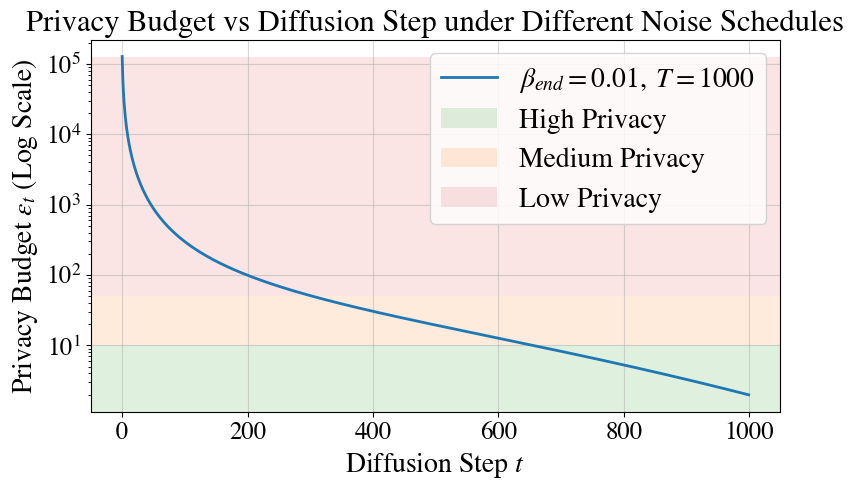

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Use Times-style serif fonts (including math)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times', 'STIXGeneral']
rcParams['mathtext.fontset'] = 'stix'   # Make math text consistent with Times

# ===== Original configuration =====
T1 = 1000
alpha_bar_1 = compute_alpha_bar(1e-4, 0.01, T1)
eps_t_1 = compute_eps_per_step(alpha_bar_1, delta=1e-5, Delta_f0=5.0)
t1 = np.arange(T1)

# ===== Plot =====
plt.figure(figsize=(8, 5))

# Two epsilon curves
plt.plot(
    t1, eps_t_1, linewidth=2, color='#1f77b4',
    label=r'$\beta_{end}=0.01,\; T=1000$'
)

# ===== Privacy regions =====
plt.axhspan(0, 10, facecolor='#2ca02c', alpha=0.15, label='High Privacy')
plt.axhspan(10, 50, facecolor='#ff7f0e', alpha=0.15, label='Medium Privacy')
plt.axhspan(
    50, max(eps_t_1.max(), 100),  # Ensure the upper bound is reasonable
    facecolor='#d62728', alpha=0.12, label='Low Privacy'
)

# Log-scale y-axis
plt.yscale('log')

plt.xlabel("Diffusion Step $t$", fontsize=20)
plt.ylabel(r"Privacy Budget $\epsilon_t$ (Log Scale)", fontsize=20)
plt.title(
    r"Privacy Budget vs Diffusion Step under Different Noise Schedules",
    fontsize=22
)

# Enlarge tick labels
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.grid(False, which="minor")
plt.legend(loc='upper right', fontsize=20)
plt.tight_layout()
plt.savefig("privacy_budget_compare.pdf", dpi=300, bbox_inches="tight")
plt.show()

## Sensitivity Analysis

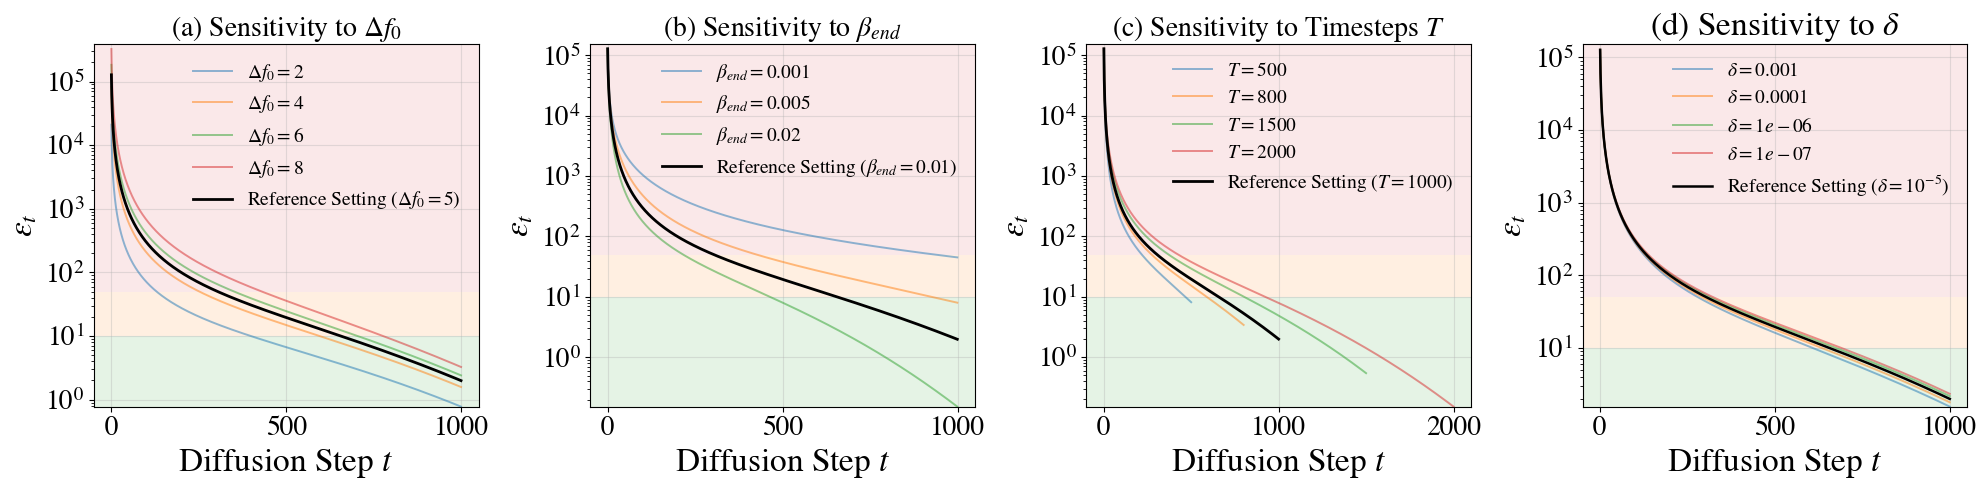

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# =========================
# Functions
# =========================
def compute_eps_per_step(alpha_bar, delta=1e-5, Delta_f0=1.0):
    alpha_bar = np.asarray(alpha_bar, dtype=np.float64)
    denom = np.sqrt(np.maximum(1.0 - alpha_bar, 1e-12))
    a_t = (np.sqrt(alpha_bar) * Delta_f0) / denom
    tail = np.sqrt(2.0 * np.log(1.0 / delta))
    return 0.5 * a_t**2 + a_t * tail


def compute_alpha_bar(beta_start, beta_end, T):
    betas = np.linspace(beta_start, beta_end, T)
    return np.cumprod(1 - betas)


def add_privacy_regions(ax, ymin, ymax):
    ax.axhspan(ymin, 10, facecolor='#2ca02c', alpha=0.12, zorder=0)
    ax.axhspan(10, 50, facecolor='#ff7f0e', alpha=0.12, zorder=0)
    ax.axhspan(50, ymax, facecolor='#d62728', alpha=0.10, zorder=0)

from matplotlib.ticker import LogLocator, LogFormatterMathtext

def set_uniform_log_yticks(ax):
    ax.yaxis.set_major_locator(LogLocator(base=10.0))
    ax.yaxis.set_major_formatter(LogFormatterMathtext())

    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1))

    ax.grid(True, which="major", alpha=0.35)
    ax.grid(False, which="minor")
    
# =========================
# Style
# =========================
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times', 'STIXGeneral']
rcParams['mathtext.fontset'] = 'stix'

# =========================
# Reference setting
# =========================
beta_start = 1e-4
beta_end_ref = 0.01
T_ref = 1000
Delta_f0_ref = 5
delta_ref = 1e-5

alpha_bar_ref = compute_alpha_bar(beta_start, beta_end_ref, T_ref)
t_ref = np.arange(T_ref)
eps_ref = compute_eps_per_step(alpha_bar_ref, delta_ref, Delta_f0_ref)

# =========================
# Figure
# =========================
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs = axs.flatten()

# =========================================================
# (a) Δf0 sweep
# =========================================================
Delta_f0_list = [2, 4, 6, 8]
eps_all = []

for d0 in Delta_f0_list:
    eps = compute_eps_per_step(alpha_bar_ref, delta_ref, d0)
    eps_all.append(eps)
    axs[0].plot(t_ref, eps, linewidth=1.4, alpha=0.5,
                label=rf'$\Delta f_0={d0}$')

axs[0].plot(t_ref, eps_ref, color='black', linewidth=2.0,
            label=r'Reference Setting ($\Delta f_0=5$)')

ymin, ymax = min(e.min() for e in eps_all + [eps_ref]), \
             max(e.max() for e in eps_all + [eps_ref]) * 1.2
axs[0].set_yscale("log")
axs[0].set_ylim(ymin, ymax)
add_privacy_regions(axs[0], ymin, ymax)

axs[0].set_title("(a) Sensitivity to $\\Delta f_0$", fontsize=20)
axs[0].legend(frameon=False)

# =========================================================
# (b) β_end sweep
# =========================================================
beta_end_list = [0.001, 0.005, 0.02]
eps_all = []

for be in beta_end_list:
    alpha_bar = compute_alpha_bar(beta_start, be, T_ref)
    eps = compute_eps_per_step(alpha_bar, delta_ref, Delta_f0_ref)
    eps_all.append(eps)
    axs[1].plot(t_ref, eps, linewidth=1.4, alpha=0.5,
                label=rf'$\beta_{{end}}={be}$')

axs[1].plot(t_ref, eps_ref, color='black', linewidth=2.0,
            label=r'Reference Setting ($\beta_{end}=0.01$)')

ymin, ymax = min(e.min() for e in eps_all + [eps_ref]), \
             max(e.max() for e in eps_all + [eps_ref]) * 1.2
axs[1].set_yscale("log")
axs[1].set_ylim(ymin, ymax)
add_privacy_regions(axs[1], ymin, ymax)

axs[1].set_title("(b) Sensitivity to $\\beta_{end}$",fontsize=20)
axs[1].legend(frameon=False)

# =========================================================
# (c) T sweep
# =========================================================
T_list = [500, 800, 1500, 2000]
eps_all = []

for T in T_list:
    alpha_bar = compute_alpha_bar(beta_start, beta_end_ref, T)
    eps = compute_eps_per_step(alpha_bar, delta_ref, Delta_f0_ref)
    eps_all.append(eps)
    axs[2].plot(np.arange(T), eps, linewidth=1.4, alpha=0.5,
                label=rf'$T={T}$')

axs[2].plot(t_ref, eps_ref, color='black', linewidth=2.0,
            label=r'Reference Setting ($T=1000$)')

ymin, ymax = min(e.min() for e in eps_all + [eps_ref]), \
             max(e.max() for e in eps_all + [eps_ref]) * 1.2
axs[2].set_yscale("log")
axs[2].set_ylim(ymin, ymax)
add_privacy_regions(axs[2], ymin, ymax)

axs[2].set_title("(c) Sensitivity to Timesteps $T$",fontsize=20)
axs[2].legend(frameon=False)

# =========================================================
# (d) δ sweep
# =========================================================
delta_list = [1e-3, 1e-4, 1e-6, 1e-7]
eps_all = []

for d in delta_list:
    eps = compute_eps_per_step(alpha_bar_ref, d, Delta_f0_ref)
    eps_all.append(eps)
    axs[3].plot(t_ref, eps, linewidth=1.4, alpha=0.5,
                label=rf'$\delta={d}$')

axs[3].plot(t_ref, eps_ref, color='black', linewidth=1.8,
            label=r'Reference Setting ($\delta=10^{-5}$)')

ymin, ymax = min(e.min() for e in eps_all + [eps_ref]), \
             max(e.max() for e in eps_all + [eps_ref]) * 1.2
axs[3].set_yscale("log")
axs[3].set_ylim(ymin, ymax)
add_privacy_regions(axs[3], ymin, ymax)

axs[3].set_title("(d) Sensitivity to $\\delta$",fontsize=24)
axs[3].legend(frameon=False)

# =========================
# Common formatting
# =========================
for ax in axs:
    ax.set_xlabel("Diffusion Step $t$",fontsize=24)
    ax.set_ylabel(r"$\epsilon_t$", fontsize=24)
    # ax.grid(True, which="both", alpha=0.35)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    set_uniform_log_yticks(ax)
    ax.legend(
    frameon=False,
    fontsize=14
)

# plt.suptitle(
#     r"Privacy Budget Sensitivity Analysis "
#     r"(Reference Setting: $\beta_{end}=0.01,\;T=1000,\;\Delta f_0=5,\;\delta=10^{-5}$)",
#     fontsize=24
# )

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("sensativity.pdf", dpi=300, bbox_inches="tight")
plt.show()